In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [8]:
from skimage import io

# read the image stack
# Original values in tif images are scaled between 0-255
demand_img = io.imread('inputDemandCost_1180.tif')
demand_img = np.array(demand_img)
print(demand_img.shape)

LastIterLine_img = io.imread('LastIterLine_1180.tif')
LastIterLine_img = np.array(LastIterLine_img)
print(LastIterLine_img.shape)

LastIterRU_img = io.imread('LastIterRU_1180.tif')
LastIterRU_img = np.array(LastIterRU_img)
print(LastIterRU_img.shape)

LastIterRD_img = io.imread('LastIterRD_1180.tif')
LastIterRD_img = np.array(LastIterRD_img)
print(LastIterRD_img.shape)

Nunits=540
Nbus=1180
Nbranch=1905
Horizon=24
#n_scenario=np.size(demand_img,0)

(600, 1180, 32, 3)
(600, 1905, 24)
(600, 540, 23)
(600, 540, 23)


In [10]:
# normalizing between 0-1
demand_img=(demand_img/255)
LastIterLine_img=(LastIterLine_img/255)   
LastIterRU_img=(LastIterRU_img/255)
LastIterRD_img=(LastIterRD_img/255)

In [11]:
#converting to original values
#as input was converted to images (0 to 255)
maxDem=527.1443
maxcostA=0.0802
maxcostB=43.3513

demand_img[0:,0:,0:,0]=demand_img[0:,0:,0:,0]*maxDem
demand_img[0:,0:,0:,1]=demand_img[0:,0:,0:,1]*maxcostA
demand_img[0:,0:,0:,2]=demand_img[0:,0:,0:,2]*maxcostB

In [12]:
#dataset for training

demand_img_train=demand_img[0:4075,0:,0:,0:]
LastIterLine_img_train=LastIterLine_img[0:4075,0:,0:]
LastIterRU_img_train=LastIterRU_img[0:4075,0:,0:]
LastIterRD_img_train=LastIterRD_img[0:4075,0:,0:]
print(demand_img_train.shape)
print(LastIterLine_img_train.shape)
print(LastIterRU_img_train.shape)
print(LastIterRD_img_train.shape)

#normalizing training data
#finding the stat of training data
maxD=np.amax(demand_img_train[0:,0:,0:,0])
maxB=np.amax(demand_img_train[0:,0:,0:,1])
maxA=np.amax(demand_img_train[0:,0:,0:,2])

demand_img_train[0:,0:,0:,0]=demand_img_train[0:,0:,0:,0]/maxD
demand_img_train[0:,0:,0:,1]=demand_img_train[0:,0:,0:,1]/maxB
#demand_img[0:,0:,0:,2]=demand_img[0:,0:,0:,2]/maxA #this channel is zero for linear cost (0 division)

#Reshaping training data
n_scenario=np.size(demand_img_train,0)
#n_training_scenario=np.size(demand_img_train,0)
x_train_demand_line=np.reshape(demand_img_train,(n_scenario,Nbus,32,3))
x_train_demand_rampRU=np.copy(x_train_demand_line)
x_train_demand_rampRD=np.copy(x_train_demand_line)
y_train_line=np.reshape(LastIterLine_img_train,(n_scenario,Nbranch*24),'F')
y_train_rampRU=np.reshape(LastIterRU_img_train,(n_scenario,Nunits*23),'F')
y_train_rampRD=np.reshape(LastIterRD_img_train,(n_scenario,Nunits*23),'F')

print(x_train_demand_line.shape)
print(y_train_line.shape)
print(y_train_rampRU.shape)
print(y_train_rampRD.shape)

(600, 1180, 32, 3)
(600, 1905, 24)
(600, 540, 23)
(600, 540, 23)
(600, 1180, 32, 3)
(600, 45720)
(600, 12420)
(600, 12420)


In [13]:
#dataset for testing

demand_img_test=demand_img[4075:,0:,0:,0:]
LastIterLine_img_test=LastIterLine_img[4075:,0:,0:]
LastIterRU_img_test=LastIterRU_img[4075:,0:,0:]
LastIterRD_img_test=LastIterRD_img[4075:,0:,0:]
print(demand_img_test.shape)
print(LastIterLine_img_test.shape)
print(LastIterRU_img_test.shape)
print(LastIterRD_img_test.shape)

#normalizing testing data
demand_img_test[0:,0:,0:,0]=demand_img_test[0:,0:,0:,0]/maxD
demand_img_test[0:,0:,0:,1]=demand_img_test[0:,0:,0:,1]/maxB

#Reshaping testing data
n_scenario=np.size(demand_img_test,0)
#n_test_scenario=np.size(demand_img_test,0)
x_test_demand_line=np.reshape(demand_img_test,(n_scenario,Nbus,32,3))
x_test_demand_rampRU=np.copy(x_test_demand_line)
x_test_demand_rampRD=np.copy(x_test_demand_line)
y_test_line=np.reshape(LastIterLine_img_test,(n_scenario,Nbranch*24),'F')
y_test_rampRU=np.reshape(LastIterRU_img_test,(n_scenario,Nunits*23),'F')
y_test_rampRD=np.reshape(LastIterRD_img_test,(n_scenario,Nunits*23),'F')

n_test_scenario=np.size(demand_img_test,0)

print(x_test_demand_line.shape)
print(y_test_line.shape)
print(y_test_rampRU.shape)
print(y_test_rampRD.shape)

(0, 1180, 32, 3)
(0, 1905, 24)
(0, 540, 23)
(0, 540, 23)
(0, 1180, 32, 3)
(0, 45720)
(0, 12420)
(0, 12420)


In [14]:
import tensorflow.keras.backend as K

def f2(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return K.mean(f2)

def f2_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return 1 - K.mean(f2)

from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min',
    verbose=1
)

In [20]:
# importing EfficientNet Architecture with imagenet weights
import efficientnet.tfkeras as enet
base = enet.EfficientNetB7(include_top=False, weights='imagenet',pooling='avg')

268320768/268317848 [==============================] - 14s 0us/step


In [17]:
# training and finetunig the modified EfficientNet architecture with imagenet weights
model_line = Sequential()
model_line.add(base)
model_line.add(Flatten())
model_line.add(Dense(2048, activation='relu'))
model_line.add(Dense(Nbranch*24, activation='sigmoid'))

for layer in model_line.layers[:-3]:
    layer.trainable=False
model_line.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
#history_line =model_line.fit(x_train_demand_line, y_train_line, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_line.layers[:-13]:
    layer.trainable=False
for layer in model_line.layers[-13:]:
    layer.trainable=True

model_line.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])   
#history_line =model_line.fit(x_train_demand_line, y_train_line, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

In [19]:
# training and finetunig the modified EfficientNet architecture with imagenet weights

model_rampRU = Sequential()
model_rampRU.add(base)
model_rampRU.add(Flatten())
model_rampRU.add(Dense(512, activation='relu'))
model_rampRU.add(Dense(Nunits*23, activation='sigmoid'))

for layer in model_rampRU.layers[:-3]:
    layer.trainable=False
model_rampRU.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
#history_rampRU =model_rampRU.fit(x_train_demand_rampRU, y_train_rampRU, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_rampRU.layers[:-10]:
    layer.trainable=False
for layer in model_rampRU.layers[-10:]:
    layer.trainable=True

model_rampRU.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])
#history_rampRU =model_rampRU.fit(x_train_demand_rampRU, y_train_rampRU, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

In [12]:
# training and finetunig the modified EfficientNet architecture with imagenet weights

model_rampRD = Sequential()
model_rampRD.add(base)
model_rampRD.add(Flatten())
model_rampRD.add(Dense(512, activation='relu'))
model_rampRD.add(Dense(Nunits*23, activation='sigmoid'))

for layer in model_rampRD.layers[:-3]:
    layer.trainable=False
model_rampRD.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
history_rampRD =model_rampRD.fit(x_train_demand_rampRD, y_train_rampRD, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_rampRD.layers[:-13]:
    layer.trainable=False
for layer in model_rampRD.layers[-13:]:
    layer.trainable=True

model_rampRD.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])
history_rampRD =model_rampRD.fit(x_train_demand_rampRD, y_train_rampRD, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

Train on 3667 samples, validate on 408 samples
Epoch 1/10
3667/3667 [==============================] - 1763s 481ms/sample - loss: 0.7994 - accuracy: 0.1688 - f2: 0.2040 - val_loss: 0.7934 - val_accuracy: 0.2255 - val_f2: 0.2047
Epoch 2/10
3667/3667 [==============================] - 1774s 484ms/sample - loss: 0.7931 - accuracy: 0.2427 - f2: 0.2067 - val_loss: 0.7934 - val_accuracy: 0.2255 - val_f2: 0.2047
Epoch 3/10
3667/3667 [==============================] - 1768s 482ms/sample - loss: 0.7930 - accuracy: 0.2479 - f2: 0.2069 - val_loss: 0.7934 - val_accuracy: 0.2255 - val_f2: 0.2047
Epoch 4/10
3667/3667 [==============================] - 1764s 481ms/sample - loss: 0.7932 - accuracy: 0.2525 - f2: 0.2066 - val_loss: 0.7934 - val_accuracy: 0.2255 - val_f2: 0.2047
Epoch 5/10
3667/3667 [==============================] - 1755s 479ms/sample - loss: 0.7930 - accuracy: 0.2411 - f2: 0.2069 - val_loss: 0.7934 - val_accuracy: 0.2255 - val_f2: 0.2047
Epoch 6/10
3667/3667 [==========================

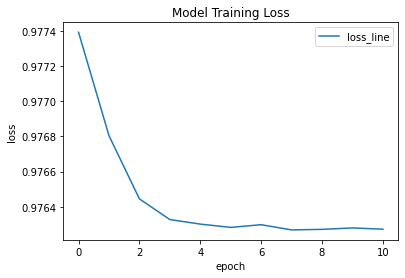

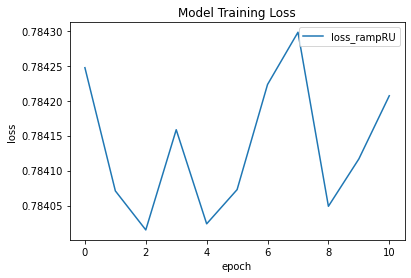

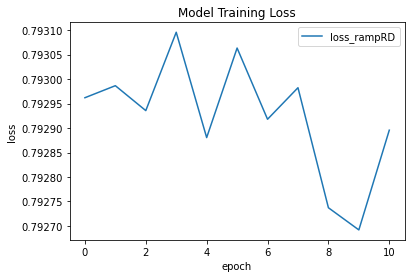

In [13]:
#print(history.history.keys())
import matplotlib.pyplot as plt

plt.plot(history_line.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_line'], loc='upper right')          
plt.show()

plt.plot(history_rampRU.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_rampRU'], loc='upper right')          
plt.show()

plt.plot(history_rampRD.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_rampRD'], loc='upper right')          
plt.show()

In [17]:
# prediction 
y_pred_line=model_line.predict(x_test_demand_line)
y_pred_rampRU=model_rampRU.predict(x_test_demand_rampRU)
y_pred_rampRD=model_rampRD.predict(x_test_demand_rampRD)
print(y_pred_line.shape)
print(y_pred_rampRU.shape)
print(y_pred_rampRD.shape)

(1000, 45720)
(1000, 12420)
(1000, 12420)


In [18]:
from sklearn.metrics import confusion_matrix

#testing the Branch classifier
y_test=np.reshape(y_test_line,np.size(y_test_line,0)*np.size(y_test_line,1),'c')
y_pred=np.reshape(y_pred_line,np.size(y_test_line,0)*np.size(y_test_line,1),'c')

probability_fitering=np.array([0.999])

y_predline=np.copy(y_pred)
y_predline[y_predline >= probability_fitering] = 1
y_predline[y_predline < probability_fitering] = 0
print(confusion_matrix(y_test, y_predline))

#testing the Ramp Up classifier
y_test=np.reshape(y_test_rampRU,np.size(y_test_rampRU,0)*np.size(y_test_rampRU,1),'c')
y_pred=np.reshape(y_pred_rampRU,np.size(y_test_rampRU,0)*np.size(y_test_rampRU,1),'c')

y_predRU=np.copy(y_pred)
y_predRU[y_predRU >= probability_fitering] = 1
y_predRU[y_predRU < probability_fitering] = 0
print(confusion_matrix(y_test, y_predRU))

#testing the Ramp Down classifier
y_test=np.reshape(y_test_rampRD,np.size(y_test_rampRD,0)*np.size(y_test_rampRD,1),'c')
y_pred=np.reshape(y_pred_rampRD,np.size(y_test_rampRD,0)*np.size(y_test_rampRD,1),'c')

y_predRD=np.copy(y_pred)
y_predRD[y_predRD >= probability_fitering] = 1
y_predRD[y_predRD < probability_fitering] = 0
print(confusion_matrix(y_test, y_predRD))

[[42070800  3138956]
 [    3855   506389]]
[[6016302 5109843]
 [    143 1293712]]
[[6254654 4981969]
 [    614 1182763]]


In [19]:
#ouput data reshaping
n_test_scenario=np.size(demand_img_test,0)
y_predline=np.reshape(y_predline,(n_test_scenario,Nbranch*24),'c')
y_predRU=np.reshape(y_predRU,(n_test_scenario,Nunits*23),'c')
y_predRD=np.reshape(y_predRD,(n_test_scenario,Nunits*23),'c')
print(y_predline.shape)
print(y_predRU.shape)
print(y_predRD.shape)

#Breaking each scenario into row and columns
y_predline=np.reshape(y_predline,(n_test_scenario,Nbranch,24),'F')
y_predRU=np.reshape(y_predRU,(n_test_scenario,Nunits,23),'F')
y_predRD=np.reshape(y_predRD,(n_test_scenario,Nunits,23),'F')
print(y_predline.shape)
print(y_predRU.shape)
print(y_predRD.shape)

(1000, 45720)
(1000, 12420)
(1000, 12420)
(1000, 1905, 24)
(1000, 540, 23)
(1000, 540, 23)


In [20]:
#saving the trained model
model_line.save("model_line_1180_Last.h5")
model_rampRU.save("model_rampRU_1180_Last.h5")
model_rampRD.save("model_rampRD_1180_Last.h5")

In [21]:
#saving the predicted result back to image format
from skimage import io
io.imsave('predicted_branch_const_1180_Last.tif',y_predline)
io.imsave('predicted_rampRU_const_1180_Last.tif',y_predRU)
io.imsave('predicted_rampRD_const_1180_Last.tif',y_predRD)